In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import imageio
import numpy as np
import torch
import cv2
from tqdm import tqdm
from os import makedirs
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, ModelHiddenParams #, get_combined_args,
from time import time
import open3d as o3d
from copy import deepcopy
import torch
import math
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene import Scene as DynamicScene
from static_scene import Scene as StaticScene
from scene.feature_gaussian_model import GaussianModel as DynamicGaussianModel
from static_scene. gaussian_model import GaussianModel as StaticGaussianModel
# from gaussian_renderer import render
from utils.segment_utils import get_combined_args
from utils.transform_utils_torch import *

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
model_background = "./output/drjohnson"
model0 = "./output/dynerf/flame_steak"
config0 = "arguments/dynerf/flame_steak.py"
cam_view0 = "cam16"

# model1 = "./output/dynerf/flame_steak"
# config1 = "arguments/dynerf/flame_steak.py"
model1 = "./output/dynerf/flame_salmon_1"
config1 = "arguments/dynerf/flame_salmon_1.py"
cam_view1 = "cam06"
# model1 = "./output/hypernerf/misc/americano"
# config1 = "arguments/hypernerf/default.py"

render_path = "demo"

In [3]:
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
hyperparam = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
# parser.add_argument("--skip_train", action="store_true")
# parser.add_argument("--skip_test", action="store_true")
# parser.add_argument("--quiet", action="store_true")
# parser.add_argument("--skip_video", action="store_true")
parser.add_argument("--modelpath0", type=str, default=model0)
parser.add_argument("--modelpath1", type=str, default=model1)
parser.add_argument("--configs1", type=str, default=config1)
# parser.add_argument("--configs3", type=str, default="arguments/dnerf_tv_2/mutant.py")
# parser.add_argument("--modelpath3", type=str, default="output/dnerf_tv_2/mutant")
# args = parser.parse_args(sys.argv[1:])

# model_background
# args0 = get_combined_args(parser, model_background, "scene")

# model0
args0 = get_combined_args(parser, model0, "scene")
import mmcv
from utils.params_utils import merge_hparams
config = mmcv.Config.fromfile(config0)
args0 = merge_hparams(args0, config)
args0.object_masks = False
args0.need_gt_masks = False


# model1
args1 = get_combined_args(parser, model1, "scene")
import mmcv
from utils.params_utils import merge_hparams
config = mmcv.Config.fromfile(args1.configs1)
args1 = merge_hparams(args1, config)
args1.object_masks = False
args1.need_gt_masks = False

Looking for config file in ./output/dynerf/flame_steak/cfg_args
Config file found at: ./output/dynerf/flame_steak/cfg_args
Looking for config file in ./output/dynerf/flame_salmon_1/cfg_args
Config file found at: ./output/dynerf/flame_salmon_1/cfg_args


In [4]:
# gaussians0, scene0, background = init_static_gaussians(model.extract(args0), args0.iteration)
gaussians0, scene0, background = init_dynamic_gaussians(model.extract(args0), hyperparam.extract(args0), args0.iteration, cam_view=cam_view0)
gaussians1, scene1, background = init_dynamic_gaussians(model.extract(args1), hyperparam.extract(args1), args1.iteration, cam_view=cam_view1)

# gaussians = [gaussians0, gaussians1]
gaussians = [gaussians0, gaussians1]
gaussians0.load_mask_table(os.path.join(model0, "delete", "flame_steak.pt"))
gaussians1.load_mask_table(os.path.join(model1, "segment_results", "flame_salmon.pt"))

mode:  scene
Loading trained model at iteration 14000
meta data loaded, total image:300
meta data loaded, total image:300
load finished. Train Dataset Length: 300


100%|██████████| 300/300 [00:00<00:00, 217321.45it/s]
300it [00:00, 66530.49it/s]


origin points, 37765
after points, 37765
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [20.96438789 14.43809223 42.81179047] [-27.41521454 -18.42700958   6.00896609]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 20.9644,  14.4381,  42.8118],
        [-27.4152, -18.4270,   6.0090]])
loading model from exists./output/dynerf/flame_steak/point_cloud/iteration_14000
Init ./output/dynerf/flame_steak finished

mode:  scene
Loading trained model at iteration 14000
meta data loaded, total image:300
meta data loaded, total image:300
load finished. Train Dataset Length: 300


100%|██████████| 300/300 [00:00<00:00, 219827.25it/s]
300it [00:00, 32332.69it/s]


origin points, 39112
after points, 39112
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [ 321.02844238   34.78144836 2471.38452148] [-194.2824707  -138.01019287    5.91185045]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 321.0284,   34.7814, 2471.3845],
        [-194.2825, -138.0102,    5.9119]])
loading model from exists./output/dynerf/flame_salmon_1/point_cloud/iteration_14000
Init ./output/dynerf/flame_salmon_1 finished



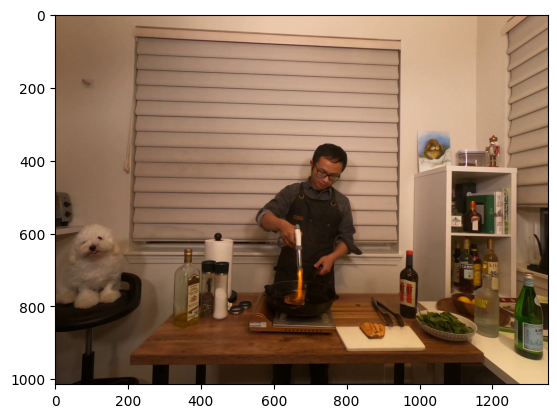

In [5]:
plt.imshow(scene0.getTrainCameras()[100].original_image.detach().cpu().numpy().transpose(1, 2, 0))

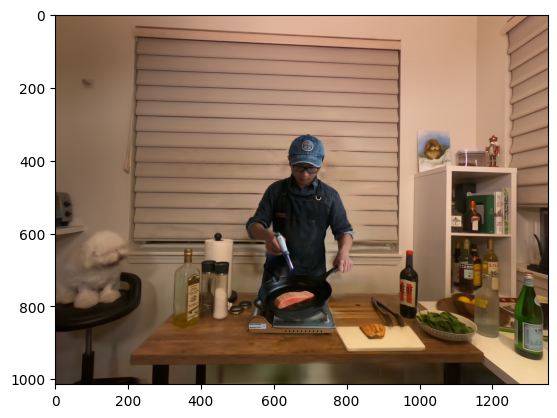

In [6]:
scales_bias0 = 1
rotation_bias0 = torch.tensor([0, 0, 0])
motion_bias0 = torch.tensor([0, 0, 0])

scales_bias1 = 1
rotation_bias1 = torch.tensor([-0.7*np.pi/128, 0, 0])
motion_bias1 = torch.tensor([-0.4, 1.8, 0])

fix_viewpoint = scene0.getTrainCameras()[0]
timestamp = scene0.getTrainCameras()[0].time

result = render(fix_viewpoint, timestamp,
                gaussians, 
                bg_color=background,
                motion_bias=[motion_bias0, motion_bias1],
                rotation_bias=[rotation_bias0, rotation_bias1],
                scales_bias = [scales_bias0, scales_bias1],
                static = [False, False],
                seg = [True,True],
                bg = True)

plt.imshow(to8b(result["render"]).transpose(1,2,0))

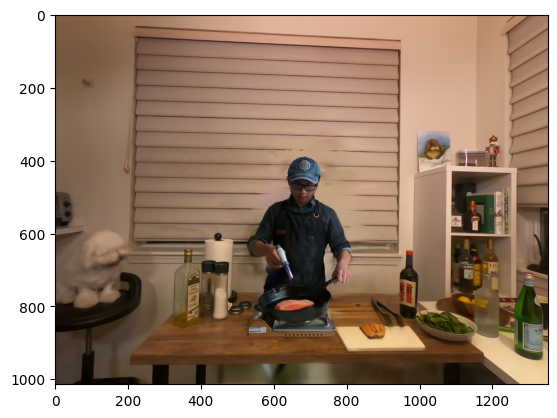

In [7]:
scales_bias0 = 1
rotation_bias0 = torch.tensor([0, 0, 0])
motion_bias0 = torch.tensor([0, 0, 0])

scales_bias1 = 1
rotation_bias1 = torch.tensor([-np.pi/16, 0, 0])
motion_bias1 = torch.tensor([-0.4, 0.3, 1])

fix_viewpoint = scene0.getTrainCameras()[0]
timestamp = scene0.getTrainCameras()[0].time

result = render(fix_viewpoint, timestamp,
                gaussians, 
                bg_color=background,
                motion_bias=[motion_bias0, motion_bias1],
                rotation_bias=[rotation_bias0, rotation_bias1],
                scales_bias = [scales_bias0, scales_bias1],
                static = [False, False],
                seg = [True,True],
                bg = True)

plt.imshow(to8b(result["render"]).transpose(1,2,0))

In [8]:
render_images=[]

if not os.path.exists(render_path):
    os.makedirs(render_path, exist_ok=True)

fix_viewpoint = scene0.getTrainCameras()[81]

for index, viewpoint in tqdm(enumerate(scene0.getVideoCameras())):
    result = render(viewpoint, viewpoint.time,
                    gaussians, 
                    bg_color=background,
                    motion_bias=[motion_bias0, motion_bias1],
                    rotation_bias=[rotation_bias0, rotation_bias1],
                    scales_bias = [scales_bias0, scales_bias1],
                    static = [False, False],
                    seg = [True,True],
                    bg = True)
    render_images.append(to8b(result["render"]).transpose(1,2,0))
    
    # torchvision.utils.save_image(result["render"],os.path.join(render_path,f"output_image{index}.png"))
    
imageio.mimwrite(os.path.join(render_path, 'composite.mp4'), render_images, fps=30) 
# points = get_state_at_time(gaussians, viewpoint)
# save_point_cloud(points, args.model_path, index)

300it [00:10, 29.41it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1352, 1014) to (1360, 1024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x665df40] Warning: data is not aligned! This can lead to a speed loss


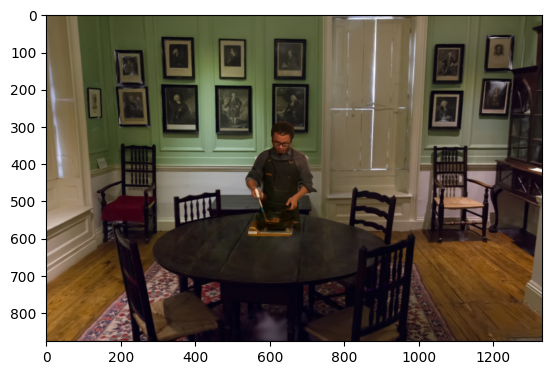

In [129]:
scales_bias1 = 0.07
rotation_bias1 = torch.tensor([np.pi/32, 1.5*np.pi/8, 1.9*np.pi/4])
motion_bias1 = torch.tensor([0.9, 0.1, 1.5])

fix_viewpoint = scene0.getTrainCameras()[81]
timestamp = scene1.getTrainCameras()[0].time

result = render(fix_viewpoint, timestamp,
                gaussians, 
                bg_color=background,
                motion_bias=[motion_bias1],
                rotation_bias=[rotation_bias1],
                scales_bias = [scales_bias1],
                static = [False, True],
                seg = [True,False],
                bg = True)

plt.imshow(to8b(result["render"]).transpose(1,2,0))

## Render Video.

In [130]:
render_images=[]

if not os.path.exists(render_path):
    os.makedirs(render_path, exist_ok=True)

fix_viewpoint = scene0.getTrainCameras()[81]

for index, viewpoint in tqdm(enumerate(scene1.getVideoCameras())):
    result = render(viewpoint, viewpoint.time,
                    gaussians, 
                    bg_color=background,
                    motion_bias=[motion_bias1],
                    rotation_bias=[rotation_bias1],
                    scales_bias = [scales_bias1],
                    bg = True,
                    static_bg = True)
    render_images.append(to8b(result["render"]).transpose(1,2,0))
    
    # torchvision.utils.save_image(result["render"],os.path.join(render_path,f"output_image{index}.png"))
    
imageio.mimwrite(os.path.join(render_path, 'composite.mp4'), render_images, fps=30) 
# points = get_state_at_time(gaussians, viewpoint)
# save_point_cloud(points, args.model_path, index)

300it [00:08, 33.64it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1332, 876) to (1344, 880) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x57d4ec0] Warning: data is not aligned! This can lead to a speed loss
